In [103]:
import os, shutil

efdir = "executingfeatures_testdata"

copyfromworkingdirectory = False
if copyfromworkingdirectory:
    efdirf = "/home/julian/.local/share/godot/app_userdata/tunnelvr_v0.5/executingfeatures"
    for f in os.listdir(efdirf):
        shutil.move(os.path.join(efdirf, f), os.path.join(efdir, f))
    os.listdir(efdir)



In [104]:
import json, numpy

polyfile = os.path.join(efdir, "polygon.txt")
x = json.loads(open(polyfile).readline())
vertices = numpy.array(x[0])
faces = numpy.array(x[1])

#var dc = "run -it --rm -v %s:/data -v %s:/code pymesh/pymesh /code/polytriangulator.py /data/polygon.txt %f /data/mesh.txt" % \
#    [ ProjectSettings.globalize_path("user://executingfeatures"), ProjectSettings.globalize_path("res://executingfeatures"), leng ]
#print(dc)
#pymeshpid = OS.execute("docker", PoolStringArray(dc.split(" ")), false)

fmeshname = os.path.join(efdir, "mesh.txt")
x = json.loads(open(fmeshname).readline())
fvertices = numpy.array(x[0])
ffaces = numpy.array(x[1]).reshape((-1, 3))



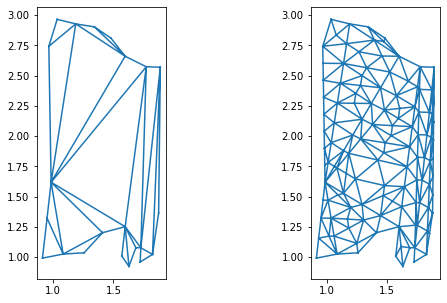

In [105]:
plt.figure(figsize=(9,5))
a = plt.subplot(121)
plt.triplot(vertices[:,0], vertices[:,1], faces)
a.set_aspect('equal')
a = plt.subplot(122)
plt.triplot(fvertices[:,0], fvertices[:,1], ffaces)
a.set_aspect('equal')



In [106]:
# code here should will project the UVs to 3D using the values here
# var xcdatalist = Centrelinedata.xcdatalistfromwingdata("res://surveyscans/wingform/Wing XYZ geometry.csv")


In [97]:
# surface mesh to flattened mesh

smeshname = os.path.join(efdir, "surfacemesh.txt")
x = json.loads(open(smeshname).readline())
svertices = numpy.array(x[0])
sfaces = numpy.array(x[1]).reshape((-1, 3))

#var freecadappimage = "/home/julian/executables/FreeCAD_0.19-24267-Linux-Conda_glibc2.12-x86_64.AppImage"
#var fmeshflattenerpy = "res://executingfeatures/meshflattener.py"
#
#var arguments = PoolStringArray([
#        ProjectSettings.globalize_path(fmeshflattenerpy), 
#        ProjectSettings.globalize_path(freecadappimage), 
#        ProjectSettings.globalize_path(fsurfacemeshname), 
#        ProjectSettings.globalize_path(fflattenedmeshname)])
#pymeshpid = OS.execute("python", arguments, false)

flmeshname = os.path.join(efdir, "flattenedmesh.txt")
x = json.loads(open(flmeshname).readline())
flvertices = numpy.array(x)

for t in sfaces:
    p0, p1, p2 = svertices[t[0]], svertices[t[1]], svertices[t[2]]
    f0, f1, f2 = flvertices[t[0]], flvertices[t[1]], flvertices[t[2]]

In [113]:
# measure change in triangle area
import math
def cross(x0, y0, z0, x1, y1, z1):
    return (y0*z1 - z0*y1, -(x0*z1 - z0*x1), x0*y1 - y0*x1)
def vlen(v):
    return math.sqrt(v[0]*v[0] + v[1]*v[1] + v[2]*v[2])

ftrianglechange = [ ]
totalmesharea, totalflatarea = 0, 0
for t in sfaces:
    p0, p1, p2 = svertices[t[0]], svertices[t[1]], svertices[t[2]]
    f0, f1, f2 = flvertices[t[0]], flvertices[t[1]], flvertices[t[2]]
    pc = cross(p1[0]-p0[0], p1[1]-p0[1], p1[2]-p0[2],  p2[0]-p0[0], p2[1]-p0[1], p2[2]-p0[2])
    fc = cross(f1[0]-f0[0], f1[1]-f0[1], 0,            f2[0]-f0[0], f2[1]-f0[1], 0)
    pa = 0.5*vlen(pc)
    fa = 0.5*vlen(fc)
    d = fa/pa
    totalmesharea += pa
    totalflatarea += fa
    ftrianglechange.append(d)
ftrianglechange = numpy.array(ftrianglechange)
print("trichange range", min(ftrianglechange), max(ftrianglechange))
print("totalflatarea", totalflatarea, " totalmesharea", totalmesharea)


trichange range 0.710269143561142 1.2705142234051519
totalflatarea 1.2337814673485856  totalmesharea 1.2336298626476767


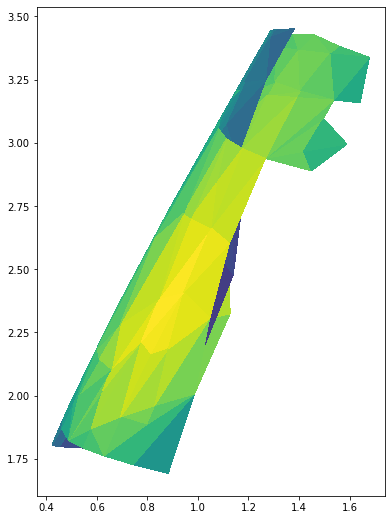

In [114]:
fig = plt.figure(figsize=(15,9))
a = plt.subplot(111)
a.set_aspect('equal')
plt.tripcolor(svertices[:,0], svertices[:,2], sfaces, svertices[:,1])

trichange range 0.710269143561142 1.2705142234051519


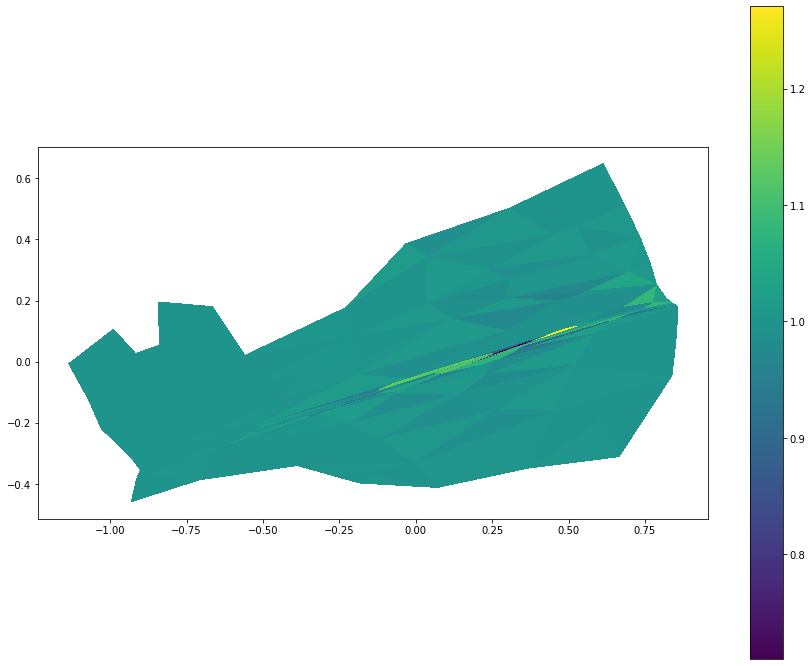

In [112]:
fig = plt.figure(figsize=(15,12))
a = plt.subplot(111)
a.set_aspect('equal')
#plt.triplot(flvertices[:,0], flvertices[:,1], sfaces)
tpc = plt.tripcolor(flvertices[:,0], flvertices[:,1], sfaces, ftrianglechange)
fig.colorbar(tpc)



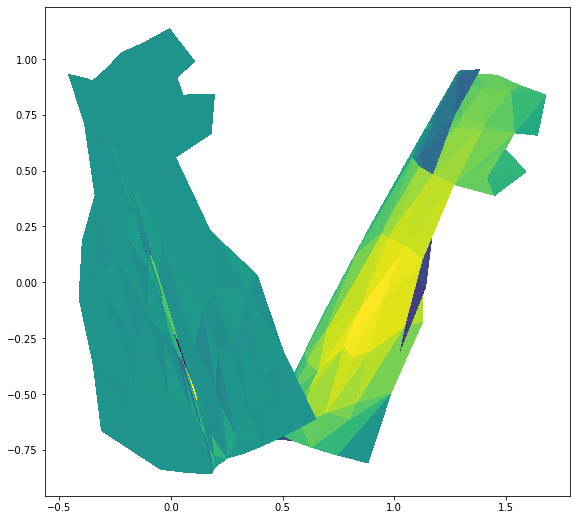

In [120]:
fig = plt.figure(figsize=(15,9))
a = plt.subplot(111)
a.set_aspect('equal')
plt.tripcolor(svertices[:,0], svertices[:,2]-2.5, sfaces, svertices[:,1])
plt.tripcolor(flvertices[:,1], -flvertices[:,0], sfaces, ftrianglechange)
